# TensorFlow Tutorial #03
# PrettyTensor

Adapted from the repository by:

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

This tutorial shows how to use the add-on package for TensorFlow called [PrettyTensor](https://github.com/google/prettytensor), which is also developed by Google. PrettyTensor provides much simpler ways of constructing Neural Networks in TensorFlow, thus allowing us to focus on the idea we wish to implement and not worry so much about low-level implementation details. This also makes the source-code much shorter and easier to read and modify.

Most of the source-code in this tutorial is identical to Tutorial #02 except for the graph-construction which is now done using PrettyTensor, as well as some other minor changes.

This tutorial builds directly on Tutorial #02 and it is recommended that you study that tutorial first if you are new to TensorFlow. You should also be familiar with basic linear algebra, Python and the Jupyter Notebook editor.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [3]:
pt.__version__

'0.7.4'

## Load Data

The example below uses the MNIST data-set which is a set of digit images ~12 MB in size and will be downloaded automatically if it is not located in the given path.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

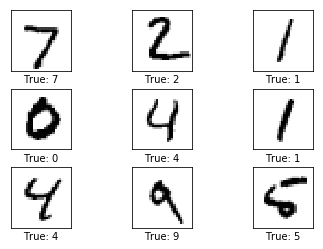

In [9]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [11]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [13]:
y_true_cls = tf.argmax(y_true, dimension=1)

## PrettyTensor Implementation

This section shows how to make an implementation of a Convolutional Neural Network using PrettyTensor.

The basic idea is to wrap the input tensor `x_image` in a PrettyTensor object which has helper-functions for adding new computational layers so as to create an entire Neural Network. This is a bit similar to the helper-functions we implemented above, but it is even simpler because PrettyTensor also keeps track of each layer's input and output dimensionalities, etc.

In [14]:
x_pretty = pt.wrap(x_image)

Now that we have wrapped the input image in a PrettyTensor object, we can add the convolutional and fully-connected layers in just a few lines of source-code.

Note that `pt.defaults_scope(activation_fn=tf.nn.relu)` makes `activation_fn=tf.nn.relu` an argument for each of the layers constructed inside the `with`-block, so that Rectified Linear Units (ReLU) are used for each of these layers. The `defaults_scope` makes it easy to change arguments for all of the layers.

In [15]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

We have now created the exact same Convolutional Neural Network in a few simple lines of code that required many complex lines of code in the direct TensorFlow implementation.

Using PrettyTensor instead of TensorFlow, we can clearly see the network structure and how the data flows through the network. This allows us to focus on the main ideas of the Neural Network rather than low-level implementation details. It is simple and pretty!

### Getting the Weights

Unfortunately, not everything is pretty when using PrettyTensor.

Further below, we want to plot the weights of the convolutional layers. In the TensorFlow implementation we had created the variables ourselves so we could just refer to them directly. But when the network is constructed using PrettyTensor, all the variables of the layers are created indirectly by PrettyTensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes (not to be confused with `defaults_scope` as described above). PrettyTensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [16]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the weighting variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [17]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Optimization Method

PrettyTensor gave us the predicted class-label (`y_pred`) as well as a loss-measure that must be minimized, so as to improve the ability of the Neural Network to classify the input images.

It is unclear from the documentation for PrettyTensor whether the loss-measure is cross-entropy or something else. But we now use the `AdamOptimizer` to minimize the loss.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Performance Measures

We need a few more performance measures to display the progress to the user.

First we calculate the predicted class number from the output of the Neural Network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [19]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [22]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [23]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [24]:
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [25]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [26]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [27]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [28]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [29]:
print_test_accuracy()

Accuracy on Test-Set: 11.7% (1167 / 10000)


## Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [30]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  14.1%
Time usage: 0:00:00


In [31]:
print_test_accuracy()

Accuracy on Test-Set: 12.6% (1256 / 10000)


# Training complete, additional examples are below for additional training cycles and additional plotting of data but all are optional

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [34]:
ls

 Volume in drive C is OSDisk
 Volume Serial Number is 9465-F9CC

 Directory of C:\Users\Albrecht\tensorflow

04/03/2017  03:21 PM    <DIR>          .
04/03/2017  03:21 PM    <DIR>          ..
04/03/2017  02:31 PM    <DIR>          .ipynb_checkpoints
04/03/2017  03:21 PM           243,161 03_PrettyTensor.ipynb
04/03/2017  12:27 PM    <DIR>          data
11/02/2016  07:53 PM                14 Test1.txt
               2 File(s)        243,175 bytes
               4 Dir(s)   6,396,047,360 bytes free


## Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [32]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:12


Accuracy on Test-Set: 83.5% (8346 / 10000)
Example errors:


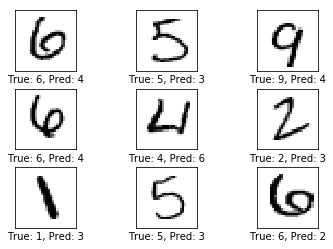

In [33]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [41]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  93.8%
Optimization Iteration:    201, Training Accuracy:  89.1%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  92.2%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  98.4%
Time usage: 0:00:03


Accuracy on Test-Set: 96.3% (9634 / 10000)
Example errors:


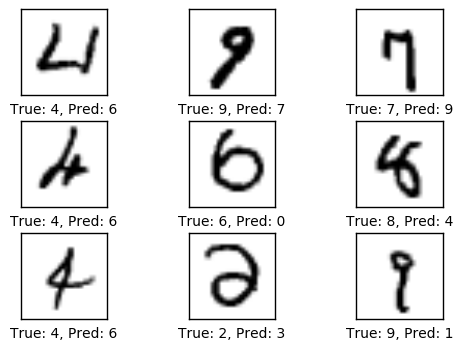

In [42]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [43]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  98.4%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  95.3%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.8% (9881 / 10000)
Example errors:


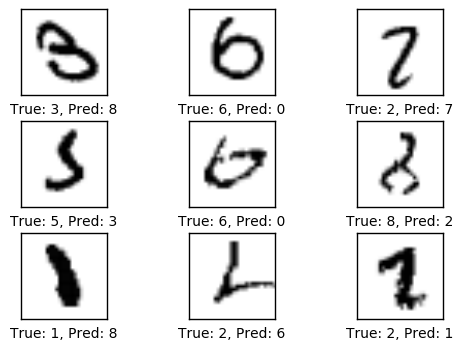

Confusion Matrix:
[[ 975    0    0    0    0    0    1    1    3    0]
 [   0 1127    2    0    0    0    1    2    3    0]
 [   2    2 1019    1    1    0    1    2    4    0]
 [   0    0    0 1005    0    1    0    1    3    0]
 [   0    0    0    0  977    0    1    0    1    3]
 [   2    0    0   13    0  870    1    0    6    0]
 [   5    2    0    0    1    3  943    0    4    0]
 [   0    2    8    2    1    0    0 1007    1    7]
 [   2    0    2    3    1    1    0    0  964    1]
 [   0    2    0    4    5    1    0    1    2  994]]


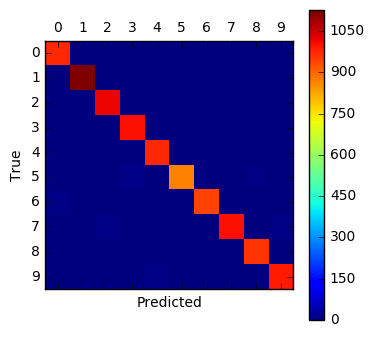

In [44]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of Weights and Layers

When the Convolutional Neural Network was implemented directly in TensorFlow, we could easily plot both the convolutional weights and the images that were output from the different layers. When using PrettyTensor instead, we can also retrieve the weights as shown above, but we cannot so easily retrieve the images that are output from the convolutional layers. So in the following we only plot the weights.

### Helper-function for plotting convolutional weights

In [45]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

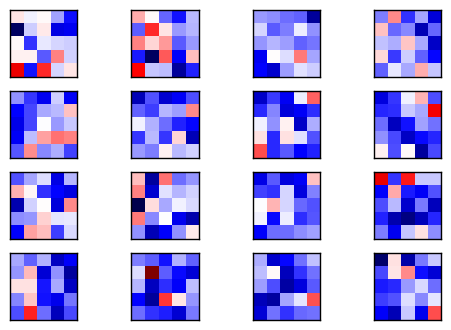

In [46]:
plot_conv_weights(weights=weights_conv1)

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

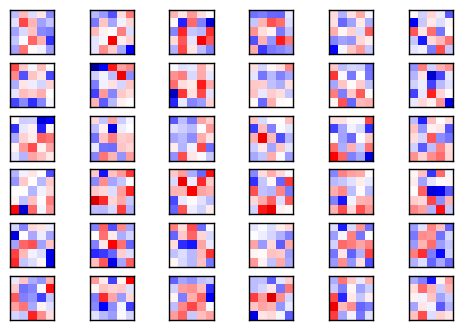

In [47]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

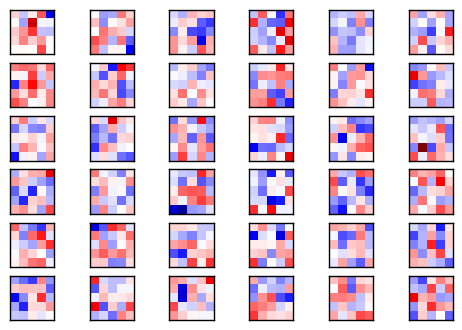

In [48]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [49]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

PrettyTensor allows you to implement Neural Networks using a much simpler syntax than a direct implementation in TensorFlow. This lets you focus on your ideas rather than low-level implementation details. It makes the code much shorter and easier to understand, and you will make fewer mistakes.

However, there are some inconsistencies and awkward designs in PrettyTensor, and it can be difficult to learn because the documentation is short and confusing. Hopefully this gets better in the future (this was written in July 2016).

There are alternatives to PrettyTensor including [TFLearn](https://github.com/tflearn/tflearn) and [Keras](https://github.com/fchollet/keras).

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change the activation function to sigmoid for all the layers.
* Use sigmoid in some layers and relu in others. Can you use `defaults_scope` for this?
* Use l2loss in all layers. Then try it for only some of the layers.
* Use PrettyTensor's reshape for `x_image` instead of TensorFlow's. Is one better than the other?
* Add a dropout-layer after the fully-connected layer. If you want a different `keep_prob` during training and testing then you will need a placeholder variable and set it in the feed-dict.
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
* Add and remove some convolutional and fully-connected layers.
* What is the simplest network you can design that still performs well?
* Retrieve the bias-values for the convolutional layers and print them. See `get_weights_variable()` for inspiration.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.